In [1]:
# Load the tfa model 
from pytfa.io.json import load_json_model
model_file = 'reduced_model_ETC_core_20240816-155234_continuous.json'
tmodel = load_json_model(model_file)
#sol = tmodel.optimize()

2025-01-02 16:45:09,282 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [2]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated.yml"))

# We calculate control coeffcients with respect
#  to enzyme activity and boundary concentrations
parameter_list = TabDict([(k, p.symbol) for k, p in kmodel.parameters.items() if p.name.startswith('vmax_forward')])
boundary_parameters = TabDict([(c.reactant.name, c.reactant.symbol) for c in kmodel.boundary_conditions.values()])
parameter_list.update(boundary_parameters)

# Compile the jacobian expressions
NCPU = 12
kmodel.prepare()
kmodel.compile_mca(ncpu=NCPU, parameter_list=parameter_list)

In [3]:
# Load TFA samples 
import pandas as pd
tfa_sample_file = 'reduced_model_ETC_core_20240816-155234_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)

In [4]:
# Get  differences to the mean of tfa_tables 
tfa_samples['cyt_atp2adp'].min() *1.2

6.63768862649245

In [5]:
# Load parameter samples 
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters.hdf5'))

In [6]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 umol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

In [7]:
# Parameter selection 
from skimpy.analysis.oracle.load_pytfa_solution import load_fluxes, load_concentrations,\
    load_equilibrium_constants
import numpy as np

EPSILON = 1e-3

flux_controll_coefficients = []
parameter_sample_ids = []

for k in parameter_population._index:

    parameter_values = parameter_population[k]

    i = int(k.split(',')[0]) 
    ref_solution = tfa_samples.loc[i]


    # Load fluxes and concentrations
    fluxes = load_fluxes(ref_solution, tmodel, kmodel,
                            density=DENSITY,
                            ratio_gdw_gww=GDW_GWW_RATIO,
                            concentration_scaling=CONCENTRATION_SCALING,
                            time_scaling=TIME_SCALING)
    
    concentrations = load_concentrations(ref_solution, tmodel, kmodel,
                                            concentration_scaling=CONCENTRATION_SCALING)
    
    this_fc = kmodel.flux_control_fun(fluxes,concentrations,[parameter_values, ])

    # Prune for positive substrate control
    medium_control = this_fc.slice_by('sample', 0).loc[['L_LACt2r','GLCt1r', 'FATP1t', 'BHBt'],
                                                       ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e']]
    diag_is_positive = np.all(np.diag(medium_control.values) > 0)

    if diag_is_positive:
        flux_controll_coefficients.append(this_fc)
        parameter_sample_ids.append(k)


In [8]:
len(parameter_sample_ids)

1848

In [9]:
# Make a pruned parameter population
from skimpy.core.parameters import ParameterValuePopulation
parameter_population_pruned = [parameter_population[k] for k in parameter_sample_ids]
parameter_population_pruned = ParameterValuePopulation(parameter_population_pruned, kmodel=kmodel, index=parameter_sample_ids)

In [10]:
# Stack the results
from skimpy.utils.tensor import Tensor
import numpy as np
# Concat the data
data = np.concatenate([f._data for f in flux_controll_coefficients], axis=2)
# Conver to tensor 
indexes = flux_controll_coefficients[0].indexes['flux'], flux_controll_coefficients[0].indexes['parameter'], pd.Index(parameter_sample_ids, name='samples')
control_coefficients = Tensor(data, indexes )


In [11]:
print(f"{len(parameter_sample_ids)} models selectet which is  {len(parameter_sample_ids) / len( parameter_population._data) * 100:.1f}% of all the models")

1848 models selectet which is  100.0% of all the models


In [12]:
# Prepare the model to run an ODE simulaiton
kmodel.compile_ode(ncpu=NCPU)

In [13]:
# Build function to compute fluxes from concentrations
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_function = make_flux_fun(kmodel, QSSA)

In [14]:
from skimpy.core.parameters import ParameterValues
from tqdm import tqdm

# Function for population analysis
def steady_state_perturbation(parameter, range=np.logspace(-1,1,51,base=10) , 
                            additional_parameter_changes={},
                            time = [0,500], # 1000 min to make sure to reach steady state
                            parameter_population=parameter_population_pruned, 
                            kmodel=kmodel, 
                            flux_function=flux_function,
                            tfa_samples=tfa_samples, 
                            end_ix=-1,
                            ):
    
    # List of dataframes
    results = []

    # Run the perturbation for each parameterset
    parameter_population_index = list(parameter_population._index.keys())
    for parameter_set_id in tqdm(parameter_population_index[:end_ix]):

        # This will be a list of dataframes
        this_results = []

        thermo_index = int(parameter_set_id.split(',')[0])
        thermo_sample = tfa_samples.loc[thermo_index]

        concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                            concentration_scaling=CONCENTRATION_SCALING)

        for k in kmodel.initial_conditions:
                kmodel.initial_conditions[k] = concentrations[k]

        # Load the parameter values 
        kmodel.parameters = parameter_population[parameter_set_id]

        # Integrate additional parameters changes (fold changes)
        for k, v in additional_parameter_changes.items():
            kmodel.parameters[k].value = kmodel.parameters[k].value * v

        # Perturb the main parameter
        p0 = kmodel.parameters[parameter].value
        
        for perturbation_value in range:
            kmodel.parameters[parameter].value = perturbation_value * p0
            # Dynamic solution            
            sol = kmodel.solve_ode(time, solver_type='cvode' , max_steps=1e9, rtol=1e-6)
            # Get steady state concentrations
            steady_state_concentrations = sol.concentrations.iloc[-1]

            # Compute the fluxes at steady state
            # Get parameters value set 
            parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
            parameter_values = ParameterValues(parameter_values, kmodel)

            steady_state_fluxes = pd.Series(flux_function(steady_state_concentrations, parameters=parameter_values), 
                                            index=kmodel.reactions.keys())
            
            # Add the results to a dataframe 
            steady_state_output = pd.concat([steady_state_concentrations, steady_state_fluxes])
            # Add metadata 
            steady_state_output['pertubration'] = perturbation_value
            steady_state_output['parameter_set'] = parameter_set_id
            steady_state_output['parameter'] = parameter    
            steady_state_output['aditional_parameters'] = [f'{k}:{v:.1f}' for k,v in additional_parameter_changes.items()]

            this_results.append(steady_state_output)

        # Concatenate the results
        this_results = pd.concat(this_results, axis=1).T

        results.append(this_results)
    

    # Concatenate the results
    results = pd.concat(results)
    return results


In [15]:
# Fased level of insulin
# Compute perturbations for each fuel concentration
parameters = ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e']
results = [steady_state_perturbation(p) for p in parameters]
results = pd.concat(results)

100%|██████████| 1847/1847 [50:19<00:00,  1.64s/it]


In [16]:
# Save the results
name = model_file.replace('.json', '')
results.to_csv(f'output/{name}_steady_state_perturbation.csv')

In [17]:
# Fed levels of insulin
# Compute perturbations for each fuel concentration
parameters = ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e']
model_fed_insulin = {'vmax_forward_GLCt1r':2.5, 'vmax_forward_PFK':2.5,}
results_insulin = [steady_state_perturbation(p, additional_parameter_changes=model_fed_insulin) for p in parameters]
results_insulin = pd.concat(results_insulin)

100%|██████████| 1847/1847 [1:10:58<00:00,  2.31s/it]


In [18]:
# Save the results
name = model_file.replace('.json', '')
results_insulin.to_csv(f'output/{name}_steady_state_perturbation_fed_insulin.csv')

In [19]:
import pandas as pd 
name  = model_file.replace('.json', '')
results= pd.read_csv(f'output/{name}_steady_state_perturbation.csv')

In [ ]:
# Find parameter-sets that are sensitive to any fuel perturbation

atp_01 = results[results.pertubration ==0.1]['cyt_atp2adp'].reset_index()
atp_01 = atp_01.set_index(results[results.pertubration ==0.1]['parameter_set'])
atp_1 = results[results.pertubration ==1]['cyt_atp2adp'].reset_index()
atp_1 = atp_1.set_index(results[results.pertubration == 1]['parameter_set'])

ratios =  atp_01 / atp_1

min_ratio = ratios.groupby('parameter_set').min()

# Sensitivity to fuel perturbations
insensitive_parameters = min_ratio[min_ratio['cyt_atp2adp'] > 0.95].index


In [21]:
# Make a new parameter population that only contains the non-sensitive parameters
parameter_population_filtered = [parameter_population_pruned[k] for k in insensitive_parameters]
parameter_population_filtered = ParameterValuePopulation(parameter_population_filtered, kmodel=kmodel, index=insensitive_parameters)

In [22]:
parameter_population_filtered
# Save pruned parameter population
parameter_population_filtered.save(f'output/{name}_robust_parameters_sets.hdf5')

In [23]:
# Exclude the sensitive parameters from the results
results_filtered = results[results['parameter_set'].isin(insensitive_parameters)]

In [24]:
uptake_fluxes = ['L_LACt2r','GLCt1r', 'FATP1t', 'BHBt']

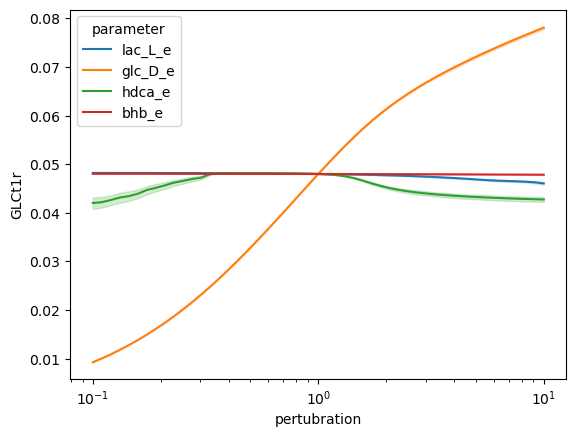

: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
# Plot the results as line plot 
sns.lineplot(data=results_filtered, x='pertubration', y='GLCt1r', hue='parameter')
plt.xscale('log', base=10)


In [ ]:
# Robusteness analysis for each regulation parmeter 

activation_parameters = [str(p.symbol) for p in kmodel.parameters.values() if 'activation' in str(p.name)]
inhibition_parameters = [str(p.symbol) for p in kmodel.parameters.values() if 'inhibition' in str(p.symbol)]

regulation_parameters = [None, ] + activation_parameters + inhibition_parameters

basic_arameters = [ 'glc_D_e', 'lac_L_e', 'bhb_e','hdca_e',]

# Robustness analysis for each regulation parmeter
robustness_results = []

# Compute perturbations for each fuel concentration
for r in regulation_parameters:
    if r is None:
        aditional_parameter_changes = {}
    else:
        aditional_parameter_changes = {r:1e4}
    
    results = [steady_state_perturbation(p, range=[0.1, 1, 10.0],
                                         additional_parameter_changes=aditional_parameter_changes) for p in basic_arameters] 
    results = pd.concat(results)

    robustness_results.append(results)

 39%|███▉      | 723/1847 [04:47<09:25,  1.99it/s]

In [ ]:
# Perturbations with a fixed membrane potential
aditional_parameter_changes = {}    
# These are common for the sodium gneralize the assingemnt 
for parameter in kmodel.parameters.values(): 
    if 'delta_psi_scaled_MPM_na1_m_na1_c' in str(parameter.symbol):
        aditional_parameter_changes[str(parameter.symbol)] = 0 


results = [steady_state_perturbation(p, range=[0.1, 1, 10.0],
                                    additional_parameter_changes=aditional_parameter_changes) for p in basic_arameters] 
results = pd.concat(results)

robustness_results.append(results)


100%|██████████| 163/163 [09:30<00:00,  3.50s/it]


In [ ]:
robustness_results

[       coa_m   aacoa_m   accoa_m    icit_m     cit_m     adp_c     atp_c  \
 0   0.002125  0.000163  0.046624  0.000981   0.38909  0.001536  0.014962   
 1   0.001985  0.000163  0.047103  0.000993   0.39224  0.001509     0.015   
 2   0.001975  0.000163  0.047136  0.000994  0.392462  0.001507  0.015003   
 0   0.002031  0.000151  0.065875  0.001248  0.426627  0.001554  0.014962   
 1   0.001969  0.000153  0.066003  0.001263  0.430845  0.001527     0.015   
 ..       ...       ...       ...       ...       ...       ...       ...   
 1   0.001975  0.000134  0.028272  0.001133  0.411057  0.001513     0.015   
 2   0.001188  0.000111  0.031852  0.001217  0.439358  0.001529  0.014955   
 0   0.005318  0.000358  0.014265  0.000252  0.097979  0.000121  0.000015   
 1   0.001975  0.000134  0.028272  0.001133  0.411057  0.001513     0.015   
 2   0.000567  0.000052  0.041302  0.002659  0.907512  0.001716  0.014653   
 
        amp_c  succoa_m    nadh_m  ... cyt_atp2adp     r0205     r0509  \


In [ ]:
# Contact the results
name = model_file.replace('.json', '')
robustness_results = pd.concat(robustness_results)
robustness_results.to_csv(f'output/{name}_robustness_analysis.csv')

In [ ]:
# Robusteness with respect to energy production
name = model_file.replace('.json', '')

robustness_results = pd.read_csv(f'output/{name}_robustness_analysis.csv')

# Clean up the the aditional parameter column
# remove []
robustness_results['aditional_parameters'] = robustness_results['aditional_parameters'].apply(lambda x: x[1:-1])
# Remove quotes
robustness_results['aditional_parameters'] = robustness_results['aditional_parameters'].apply(lambda x: x.replace("'", ""))
# Remove spaces
robustness_results['aditional_parameters'] = robustness_results['aditional_parameters'].apply(lambda x: x.replace(" ", ""))
# Remove :100 
robustness_results['aditional_parameters'] = robustness_results['aditional_parameters'].apply(lambda x: x.replace(":10000.0", ""))

# Replace the last additional parameter with a more descriptive name
robustness_results['aditional_parameters'] = robustness_results['aditional_parameters'].apply(lambda x: "membrane potential" if 'delta_psi_scaled_MPM_na1_m_na1_c' in x else x)

# Rename the delta_psi_scaled_MPM_na1_m_na1_c 
pivoted_robustness_results = robustness_results.pivot_table(index=['parameter_set', 'parameter', 'aditional_parameters'], columns='pertubration', values='cyt_atp2adp').reset_index()

In [ ]:
pivoted_robustness_results

pertubration,parameter_set,parameter,aditional_parameters,0.1,1.0,10.0
0,"0,7",bhb_e,,6.653375,6.653377,6.653379
1,"0,7",bhb_e,k_activation_AM_adp_c_PFK,6.653373,6.653375,6.653378
2,"0,7",bhb_e,k_activation_AM_adp_m_CSm,6.653351,6.653351,6.653351
3,"0,7",bhb_e,k_activation_AM_adp_m_ICDHxm,6.653205,6.653199,6.653177
4,"0,7",bhb_e,k_activation_AM_adp_m_PDHm,6.653372,6.653375,6.653377
...,...,...,...,...,...,...
18903,"93,9",lac_L_e,k_inhibition_IM_nadh_m_PDHm,6.648669,6.648831,6.648829
18904,"93,9",lac_L_e,k_inhibition_IM_pmtcoa_c_LDH_L,6.648589,6.648822,6.648840
18905,"93,9",lac_L_e,k_inhibition_IM_succoa_m_AKGDm,0.000006,6.648847,6.648869
18906,"93,9",lac_L_e,k_inhibition_IM_succoa_m_CSm,6.648847,6.648882,6.648870


In [ ]:
# Exclude the sensitive parameters from the results
pivoted_robustness_results = pivoted_robustness_results[pivoted_robustness_results['parameter_set'].isin(insensitive_parameters)]

In [ ]:
# Normalize by the reference flux of parameter_set , parameters and aditional_parameters == ""
cols = [0.1,1.0,10.0]
normalized_by_reference_parameters = pivoted_robustness_results.groupby(['parameter_set', 'parameter'])[cols].transform(lambda x: x / x.iloc[0])
normalized_by_reference_parameters.head()

pertubration,0.1,1.0,10.0
0,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000
2,0.999996,0.999996,0.999996
3,0.999975,0.999973,0.999970
4,1.000000,1.000000,1.000000


In [ ]:
normalized_by_fold_change = pivoted_robustness_results[cols].div(pivoted_robustness_results[1.0], axis=0)
normalized_by_fold_change.head()

pertubration,0.1,1.0,10.0
0,1.000000,1.0,1.000000
1,1.000000,1.0,1.000000
2,1.000000,1.0,1.000000
3,1.000001,1.0,0.999997
4,1.000000,1.0,1.000000


In [ ]:
pivoted_robustness_results[cols] = normalized_by_reference_parameters * normalized_by_fold_change
pivoted_robustness_results.head()

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_61365/3337447503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivoted_robustness_results[cols] = normalized_by_reference_parameters * normalized_by_fold_change


pertubration,parameter_set,parameter,aditional_parameters,0.1,1.0,10.0
0,"0,7",bhb_e,,1.000000,1.000000,1.000000
1,"0,7",bhb_e,k_activation_AM_adp_c_PFK,0.999999,1.000000,1.000000
2,"0,7",bhb_e,k_activation_AM_adp_m_CSm,0.999996,0.999996,0.999996
3,"0,7",bhb_e,k_activation_AM_adp_m_ICDHxm,0.999975,0.999973,0.999966
4,"0,7",bhb_e,k_activation_AM_adp_m_PDHm,0.999999,1.000000,1.000000


In [ ]:
# Count for eacher parameter and aditional parameter the number of times the flux is different from 1.0
# Use the 0.5 and 2.0 perturbations

# groupby parameter and aditional parameter
grouped = pivoted_robustness_results.groupby(['parameter', 'aditional_parameters'])

# Count the number of times the flux is different from 1.0 in the 0.5 and 2.0 columns
counted = grouped[[0.1,10.0]].apply(lambda x: (x <= 0.9).sum() + (x >= 1.1).sum()).reset_index()


<Axes: xlabel='None-parameter_set-parameter', ylabel='aditional_parameters'>

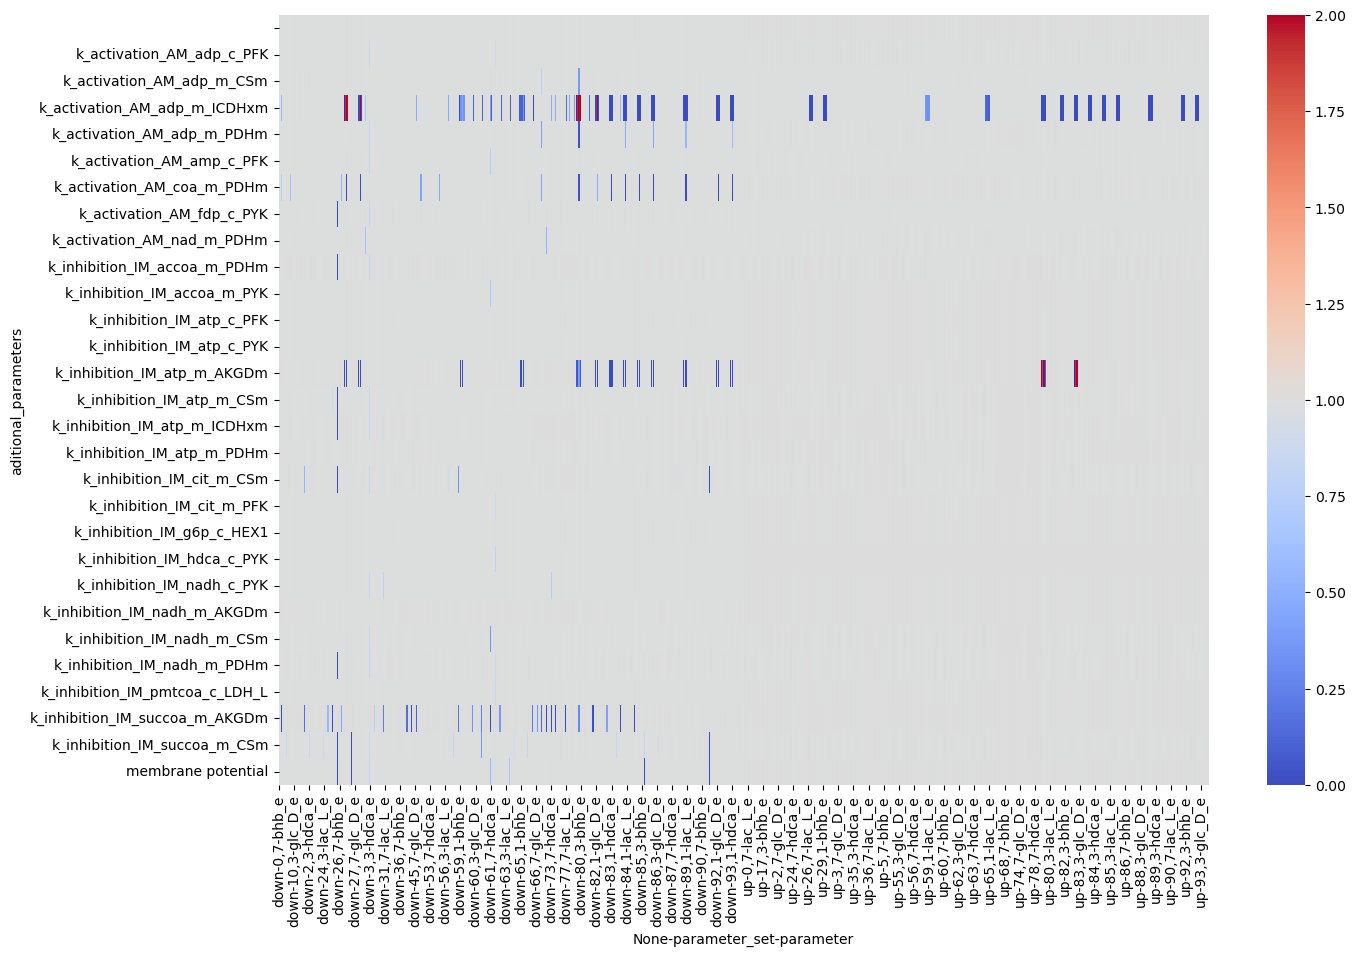

In [ ]:
# We need a better representation of the data like heat map with levels 

heat_map_results_down = pivoted_robustness_results.pivot(columns=['parameter_set','parameter'], index='aditional_parameters', values=0.1)
heat_map_results_up = pivoted_robustness_results.pivot(columns=['parameter_set','parameter'], index='aditional_parameters', values=10.0)


# Concatenate the results
heat_map_results = pd.concat([heat_map_results_down, heat_map_results_up], keys=['down', 'up'], axis=1)

# Plot the heatmap
f = plt.figure(figsize=(15,10))
sns.heatmap(heat_map_results, cmap='coolwarm', center=1.0, vmin=0.0 , vmax=2.0)


In [ ]:
pivoted_robustness_results[(pivoted_robustness_results['parameter'] == 'hdca_e') 
                           & (pivoted_robustness_results['aditional_parameters'] == '')]

pertubration,parameter_set,parameter,aditional_parameters,0.1,1.0,10.0
58,"0,7",hdca_e,,0.999991,1.0,0.999997
174,"1,3",hdca_e,,1.000001,1.0,0.999999
290,"1,7",hdca_e,,0.999993,1.0,0.999997
754,"10,3",hdca_e,,1.000001,1.0,0.999999
1102,"17,3",hdca_e,,0.999999,1.0,0.999999
...,...,...,...,...,...,...
18154,"92,3",hdca_e,,1.000001,1.0,0.999999
18270,"92,7",hdca_e,,0.999996,1.0,0.999997
18502,"93,1",hdca_e,,1.000006,1.0,0.999998
18618,"93,3",hdca_e,,1.000001,1.0,0.999999


In [ ]:
# Robusteness analysis for each regulation parmeter 

activation_parameters = [str(p.symbol) for p in kmodel.parameters.values() if 'activation' in str(p.name)]
inhibition_parameters = [str(p.symbol) for p in kmodel.parameters.values() if 'inhibition' in str(p.symbol)]

regulation_parameters = [None, ] + activation_parameters + inhibition_parameters

basic_arameters = [ 'glc_D_e', ]

baseline = {}
insulin_clamp = {'hdca_e':0.25, 'vmax_forward_GLCt1r':2.5, 'vmax_forward_PFK':2.5,}
insulin_clamp_intralipid = {'hdca_e':1.0, 'vmax_forward_GLCt1r':2.5, 'vmax_forward_PFK':2.5,}
insulin_clamp_lactate = {'hdca_e':0.25, 'vmax_forward_GLCt1r':2.5, 'vmax_forward_PFK':2.5, 'lac_L_e':2.0}
insulin_clamp_bhb = {'hdca_e':0.25, 'vmax_forward_GLCt1r':2.5, 'vmax_forward_PFK':2.5, 'bhb_e':20.0}

changes = [baseline, insulin_clamp, insulin_clamp_intralipid, insulin_clamp_lactate, insulin_clamp_bhb]

# analysis for each regulation parmeter
insulin_clamp_results = []

# Compute perturbations for each fuel concentration
for aditional_parameter_changes in changes:
    
    results = [steady_state_perturbation(p, range=[1.0,], time=[0,1000],
                                         additional_parameter_changes=aditional_parameter_changes) for p in basic_arameters] 
    results = pd.concat(results)

    insulin_clamp_results.append(results)

# Clean up
insulin_clamp_results = pd.concat(insulin_clamp_results)

100%|██████████| 163/163 [00:19<00:00,  8.47it/s]


In [ ]:

changes_names = ['baseline','insulin_clamp', 'insulin_clamp_intralipid', 'insulin_clamp_lactate', 'insulin_clamp_bhb']
naming_dict = {str([f'{i}:{j:.1f}' for i,j in changes[k].items()]):v for k,v in enumerate(changes_names)}

# Substitue the aditional parameters with the names
insulin_clamp_results['aditional_parameters'] = insulin_clamp_results['aditional_parameters'].astype(str).apply(lambda x: naming_dict[x])

insulin_clamp_results.to_csv(f'output/{name}_insulin_clamp.csv')

In [ ]:
insulin_clamp_results

,coa_m,aacoa_m,accoa_m,icit_m,cit_m,adp_c,atp_c,amp_c,succoa_m,nadh_m,...,cyt_atp2adp,r0205,r0509,r2435,NaH_antiport,Na_channel,pertubration,parameter_set,parameter,aditional_parameters
0,0.001985,0.000163,0.047103,0.000993,0.39224,0.001509,0.015,0.000304,0.015909,0.218999,...,6.653377,0.007268,0.53036,0.043136,2.514831,2.514831,1.0,"0,7",glc_D_e,baseline
0,0.001969,0.000153,0.066003,0.001263,0.430845,0.001527,0.015,0.000308,0.014035,0.189792,...,6.649675,0.023515,0.53036,0.043136,2.479085,2.479085,1.0,"1,3",glc_D_e,baseline
0,0.001969,0.000153,0.066003,0.001263,0.430845,0.001527,0.015,0.000308,0.014035,0.189792,...,6.649675,0.023515,0.53036,0.043136,2.479085,2.479085,1.0,"1,7",glc_D_e,baseline
0,0.001969,0.000153,0.066003,0.001263,0.430845,0.001527,0.015,0.000308,0.014035,0.189792,...,6.649675,0.023515,0.53036,0.043136,2.479085,2.479085,1.0,"1,9",glc_D_e,baseline
0,0.001974,0.00011,0.054291,0.001484,0.47411,0.001527,0.015,0.000267,0.011706,0.196431,...,6.650776,0.029869,0.53036,0.043136,2.454849,2.454849,1.0,"2,3",glc_D_e,baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.002313,0.001374,0.022375,0.001625,0.485404,0.001298,0.015308,0.000173,0.011917,0.205148,...,6.649545,0.055845,0.531134,0.02388,2.418926,2.418926,1.0,"92,9",glc_D_e,insulin_clamp_bhb
0,0.00414,0.002563,0.022212,0.001015,0.380712,0.00146,0.015131,0.000241,0.01658,0.211504,...,6.648873,0.040802,0.532492,0.023826,2.448387,2.448387,1.0,"93,1",glc_D_e,insulin_clamp_bhb
0,0.003353,0.004711,0.019295,0.000903,0.329067,0.001503,0.015074,0.000254,0.018135,0.191475,...,6.648843,0.06074,0.518598,0.023913,2.435174,2.435174,1.0,"93,3",glc_D_e,insulin_clamp_bhb
0,0.00244,0.001793,0.025508,0.001099,0.399432,0.001452,0.015138,0.000242,0.015744,0.222318,...,6.64888,0.097557,0.527816,0.02393,2.444201,2.444201,1.0,"93,7",glc_D_e,insulin_clamp_bhb


<Axes: xlabel='aditional_parameters', ylabel='GLCt1r'>

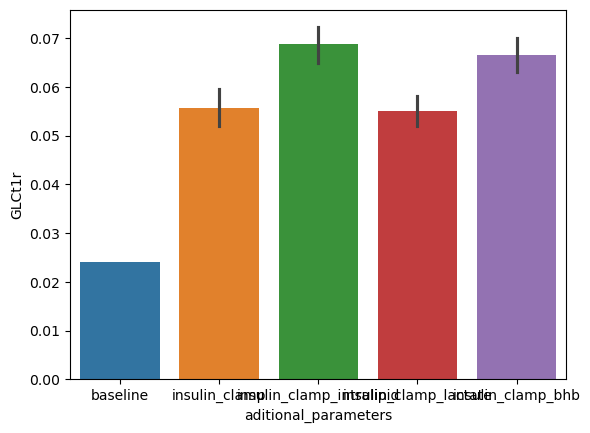

In [ ]:
sns.barplot(data=insulin_clamp_results, x='aditional_parameters', y='GLCt1r', hue='aditional_parameters')


<Axes: xlabel='aditional_parameters', ylabel='L_LACt2r'>

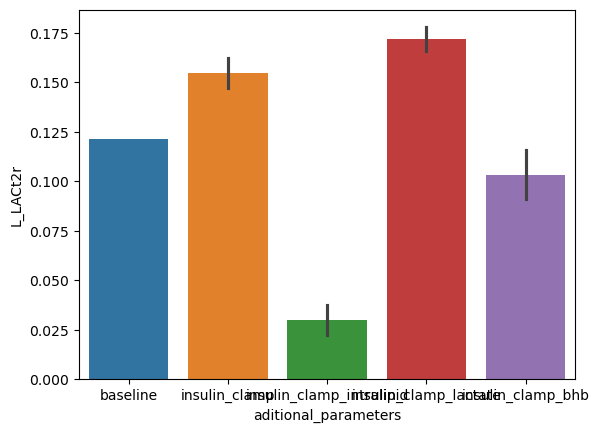

In [ ]:
sns.barplot(data=insulin_clamp_results, x='aditional_parameters', y='L_LACt2r', hue='aditional_parameters')
